In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
# Import dependencies
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with = engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table (map the classes)
ref_station = Base.classes.station
ref_measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set using max function from func to get the date
recent_dt = session.query(func.max(ref_measurement.date)).first()
recent_dt

# Note: using order_by in descending order can also return the latest/recent date.
# session.query(ref_measurement.date).order_by(ref_measurement.date.desc()).first()

('2017-08-23',)

Starting date one year from the last date: 2016-08-23


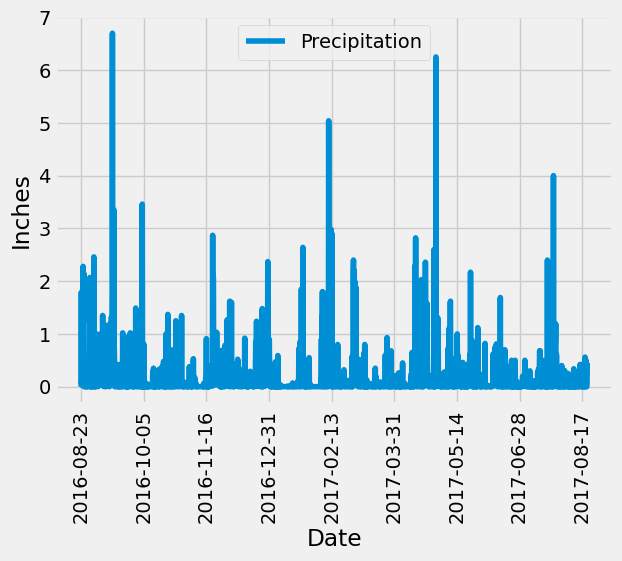

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set by:
# - convert last date into a datetime value then subtract it by 365 days using timedelta(days = 365) function
# Note: the datetime.strptime will include the time as well so need to extract only date after
start_dt = (dt.datetime.strptime(recent_dt[0], '%Y-%m-%d') - dt.timedelta(days = 365)).date()

print(f'Starting date one year from the last date: {start_dt}')

# Perform a query to retrieve the data and precipitation scores.
query = session.query(ref_measurement.date, ref_measurement.prcp).filter(ref_measurement.date >= start_dt).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
query_df = pd.DataFrame(query, columns = ['Date', 'Precipitation'])

# Sort the dataframe by date follow by index reset and finally drop any rows with NaN
query_sort_df = query_df.sort_values('Date').reset_index(drop = True).dropna()

# Use Pandas Plotting with Matplotlib to plot the data
query_sort_df.plot('Date', 'Precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation = 90)

plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
query_sort_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

### which station id has the greatest number of observations?
-  USC00519281

In [12]:
# Design a query to calculate the total number of stations in the dataset
station_counts = session.query(func.count(ref_station.station)).all()
station_counts

[(9,)]

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
stations_activity = session.query(ref_measurement.station, func.count(ref_measurement.station)). \
                            group_by(ref_measurement.station). \
                            order_by(func.count(ref_measurement.station).desc()). \
                            all()
print(stations_activity)
print(f'\nMost active station {stations_activity[0][0]}')

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]

Most active station USC00519281


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
usc00519281_tobs_stat = session.query(func.min(ref_measurement.tobs), func.max(ref_measurement.tobs), func.avg(ref_measurement.tobs)). \
                        filter(ref_measurement.station == 'USC00519281').all()
usc00519281_tobs_stat

[(54.0, 85.0, 71.66378066378067)]

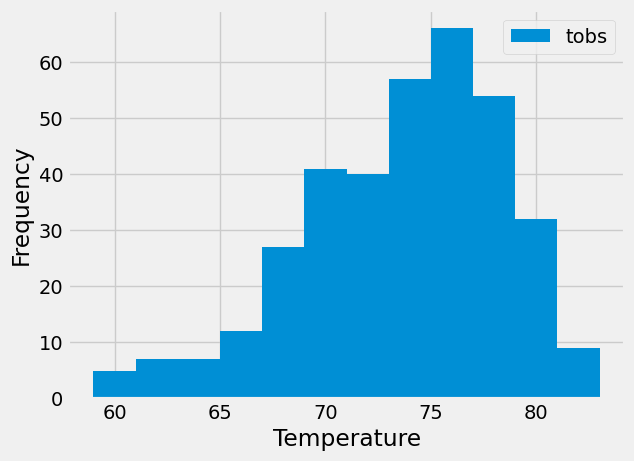

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# -----------------------------------
# Get most recent date of the station
station_recent_dt = session.query(func.max(ref_measurement.date)).filter(ref_measurement.station == 'USC00519281').first()

# Calculate the date one year from the last date in data set for the station
station_start_dt = (dt.datetime.strptime(station_recent_dt[0], '%Y-%m-%d') - dt.timedelta(days = 365)).date()

# Query the data to return the 12 months based on year and month above for the station
station_query = session.query(ref_measurement.tobs). \
                        filter(ref_measurement.date >= station_start_dt, \
                               ref_measurement.station == 'USC00519281').all()

# Create a DF that will be used to plot the histogram
station_df = pd.DataFrame(station_query)

# Plot the histogram
station_df.plot.hist(bins = 12)
plt.xlabel('Temperature')

plt.show()

# Close Session

In [16]:
# Close Session
session.close()